# Data Modelling

In this notebook we carry out most of the machine learning analysis on the dataset we had cleaned earlier. The main sections of this notebook are:

1. Data Preprocessing
2. Modelling with Pipelines
3. Interpretation of Results
4. Evaluation of Results
5. Conclusions & Recommendations

In [1]:
#basic data imports

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from random import sample

In [2]:
# NLP imports

import nltk
import regex as re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

from bs4 import BeautifulSoup    

In [3]:
#modelling imports

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

### 1.  Data Preprocessing

Here we prepare the data for modelling. We set the appropriate stopwords, as well as carry out a proper training-validation split of the data.

In [4]:
combined = pd.read_csv('datasets/combined.csv')
combined.drop(columns = 'Unnamed: 0', inplace = True)
combined.head()

,cleaned_text,subreddit
0,samsung trade program back baltic country good,0
1,vivo unveils origin o le polarizing previous one,0
2,nokia hand gsmarena,0
3,high speed high capacity u microsd card worth ...,0
4,app bundle could drawback developer power user,0


In [5]:
stops = set(stopwords.words('english'))
len(stops)

179

In [6]:
new_stops = {'iphone', 'iphones', 'android', 'phone',
             'http', 'amp', 'www', 'com', 'thread', 'reddit', 'automoderator'}

len(new_stops)

11

These stopwords have been updated after a few rounds of analysis as they keep appearing as the top 30 classifiers for the subreddits. While keeping them around may be good for prediction, it does not help in terms of understanding the differences between the two subreddits. We remove them to make a better and more explainable model.

In [7]:
updated_stops = stops.union(new_stops)
len(updated_stops)

190

In [8]:
X = combined["cleaned_text"]

In [9]:
y = combined['subreddit']

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 42, stratify = y)

In [11]:
X_train.shape

(1251,)

In [12]:
y_train.shape

(1251,)

In [13]:
y.value_counts(normalize = True)

1    0.565348
0    0.434652
Name: subreddit, dtype: float64

In [14]:
y_train.value_counts(normalize = True)

1    0.565148
0    0.434852
Name: subreddit, dtype: float64

**Stratification**

In order to ensure proportionate target classes in the training and validation datasets, we carry out stratification on the y variable and check whether it was done correctly.

## 2.  Modelling with Pipelines

We apply a few models to try and find the best one. We will use pipelines and gridsearch to find the best hyper-parameters for our transformers and estimators.

In [15]:
pipe_cv_lr = Pipeline([
    ('cvec', CountVectorizer(stop_words = updated_stops)),
    ('lr', LogisticRegression())
])

In [16]:
pipe_params = {
    'cvec__max_features': [2000, 3000, 4000],
    'cvec__min_df': [2, 3, 4],
    'cvec__max_df': [0.92, 0.95, 0.98],
    'cvec__ngram_range': [(1, 2), (1, 3)],
    'lr__C': [0.4, 0.5, 0.8]
}

In [17]:
gs_cv_lr = GridSearchCV(pipe_cv_lr, param_grid = pipe_params,
                  cv = 5, verbose = 1) 

In [18]:
gs_cv_lr.fit(X_train, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 810 out of 810 | elapsed:  3.7min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words={'a',
                                                                    'about',
                                                                    'above',
                                                                    'after',
                                                                    'again',
                                                                    'against',
                                                                    'ain',
                                                                    'all', 'am',
                                                                    'amp', 'an',
                                                                    'and',
                                                                    'android',
                                                                    'any',
       

In [19]:
gs_cv_lr.best_params_

{'cvec__max_df': 0.92,
 'cvec__max_features': 4000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'lr__C': 0.4}

In [20]:
cv_lr_model = gs_cv_lr.best_estimator_
cv_lr_model.score(X_train, y_train)

0.9856115107913669

In [21]:
cv_lr_model.score(X_val, y_val)

0.894484412470024

**Count Vectorizer + Logistic Regression**

This model seems to be doing quite well, but there does seem to be quite a bit of an overfit. The scores for the validation set dropped by 9% compared to the training score.

In [22]:
pipe_tv_lr = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = updated_stops)),
    ('lr', LogisticRegression())
])

In [23]:
pipe_params = {
    'tvec__max_features': [2000, 3000, 4000],
    'tvec__min_df': [2, 3, 4],
    'tvec__max_df': [0.85, 0.88, 0.92],
    'tvec__ngram_range': [(1, 2), (1, 3)],
    'lr__C': [0.5, 0.8, 1.0]
}

In [24]:
gs_tv_lr = GridSearchCV(pipe_tv_lr, param_grid = pipe_params,
                  cv = 5, verbose = 1)

In [25]:
gs_tv_lr.fit(X_train, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 810 out of 810 | elapsed:  3.8min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words={'a',
                                                                    'about',
                                                                    'above',
                                                                    'after',
                                                                    'again',
                                                                    'against',
                                                                    'ain',
                                                                    'all', 'am',
                                                                    'amp', 'an',
                                                                    'and',
                                                                    'android',
                                                                    'any',
       

In [26]:
gs_tv_lr.best_params_

{'lr__C': 1.0,
 'tvec__max_df': 0.85,
 'tvec__max_features': 4000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2)}

In [27]:
tv_lr_model = gs_tv_lr.best_estimator_
tv_lr_model.score(X_train, y_train)

0.9640287769784173

In [28]:
tv_lr_model.score(X_val, y_val)

0.894484412470024

The TFID-Vectorizer seems to be doing a slightly poorer job in the training score. Interestingly the validation score is exactly the same as the CountVectorizer transformer. This would suggest less overfitting.

In [29]:
pipe_cv_nb = Pipeline([
    ('cvec', CountVectorizer(stop_words = updated_stops)),
    ('nb', MultinomialNB())
])

In [30]:
pipe_params = {
    'cvec__max_features': [2000, 3000, 4000],
    'cvec__min_df': [2, 3, 4],
    'cvec__max_df': [0.82, 0.85, 0.88],
    'cvec__ngram_range': [(1, 1), (1, 2)] 
}

In [31]:
gs_cv_nb = GridSearchCV(pipe_cv_nb, param_grid = pipe_params,
                  cv = 5, verbose = 1) 

In [32]:
gs_cv_nb.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   31.6s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words={'a',
                                                                    'about',
                                                                    'above',
                                                                    'after',
                                                                    'again',
                                                                    'against',
                                                                    'ain',
                                                                    'all', 'am',
                                                                    'amp', 'an',
                                                                    'and',
                                                                    'android',
                                                                    'any',
       

In [33]:
gs_cv_nb.best_params_

{'cvec__max_df': 0.82,
 'cvec__max_features': 3000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

In [34]:
cv_nb_model = gs_cv_nb.best_estimator_
cv_nb_model.score(X_train, y_train)

0.9272581934452439

In [35]:
cv_nb_model.score(X_val, y_val)

0.8776978417266187

**Naive-Bayes Classifier**

The naive bayes model performed the poorest out all three pipeline models. But the gap between the training and validation score has the lowest gap of all, which makes it the least overfit model.

## 3.  Interpretation of Results

Here we try to interpret our results and see what are the main predictors for each subreddit.
We also attempt to find what people in these subreddits talk about the most, which could be valuable information for anyone who is invested in the Android and iPhone ecosystem.

In [36]:
pipe_tv_lr = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = updated_stops)),
    ('lr', LogisticRegression())
])

In [37]:
pipe_params = {
    'tvec__max_features': [3000, 4000, 5000],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [0.78, 0.8, 0.82],
    'tvec__ngram_range': [(1, 2), (1, 3)],
    'lr__C': [0.8, 1.0, 1.25]
}

In [38]:
gs_tv_lr = GridSearchCV(pipe_tv_lr, param_grid = pipe_params,
                  cv = 5, verbose = 1) 

Here we first instantiate the model to train on the entire dataset (training and validation combined). We will then use this model to carry out our interpretations.

We chose TFID-Vectorizer combined with Logistic Regression as it performed the best and had lesser overfitting (compared to CountVectorizer + Logistic Regression).

In [39]:
gs_tv_lr.fit(X, y)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:  3.2min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words={'a',
                                                                    'about',
                                                                    'above',
                                                                    'after',
                                                                    'again',
                                                                    'against',
                                                                    'ain',
                                                                    'all', 'am',
                                                                    'amp', 'an',
                                                                    'and',
                                                                    'android',
                                                                    'any',
       

In [40]:
gs_tv_lr.best_params_

{'lr__C': 1.25,
 'tvec__max_df': 0.78,
 'tvec__max_features': 4000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2)}

In [41]:
tv_lr_model = gs_tv_lr.best_estimator_

In [42]:
tv_lr_model.score(X, y)

0.9718225419664268

**Saving trained model**

This model is saved in a separate file, for future use/deployment.

In [43]:
import pickle

pickle.dump(tv_lr_model, open('models/trained_model.pickle', 'wb'))

In [44]:
tv_lr_model.steps

[('tvec',
  TfidfVectorizer(max_df=0.78, max_features=4000, min_df=2, ngram_range=(1, 2),
                  stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                              'ain', 'all', 'am', 'amp', 'an', 'and', 'android',
                              'any', 'are', 'aren', "aren't", 'as', 'at',
                              'automoderator', 'be', 'because', 'been', 'before',
                              'being', 'below', 'between', 'both', 'but', 'by', ...})),
 ('lr', LogisticRegression(C=1.25))]

In [45]:
tv_lr_model.steps[1][1].coef_[0]

array([ 0.16136853, -0.08677149, -0.21352989, ..., -0.09353152,
        0.30049372, -0.07255007])

In [46]:
coef_names = tv_lr_model.named_steps.tvec.get_feature_names()

coef_df = pd.DataFrame({'coefs': coef_names, 'vals' : tv_lr_model.steps[1][1].coef_[0]})

coef_df.sort_values(by='vals',ascending=False, inplace = True)

In [47]:
coef_df.head(10)

,coefs,vals
195,apple,4.599794
2563,pro,4.251984
1881,magsafe,3.131260
143,anyone,2.618064
1999,mini,2.484160
1940,max,1.972717
1668,io,1.972424
497,case,1.728386
2587,pro max,1.682557
1779,lidar,1.399152


In [48]:
coef_df.tail(10).sort_values(by = 'vals')

,coefs,vals
1406,google,-5.848867
2424,pixel,-3.969196
2275,oneplus,-3.530485
2953,samsung,-3.449185
1317,galaxy,-2.452123
2194,note,-1.942578
3644,update,-1.835084
3985,youtube,-1.814956
1143,fe,-1.765158
1555,huawei,-1.613836


In [49]:
android_coef = coef_df[coef_df['vals'] < 0]
android_coef.sort_values(by = 'vals', inplace = True)

<ipython-input-49-a9b7132a3f6d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  android_coef.sort_values(by = 'vals', inplace = True)


In [50]:
android_coef.head(3)

,coefs,vals
1406,google,-5.848867
2424,pixel,-3.969196
2275,oneplus,-3.530485


In [51]:
android_coef.reset_index(drop = True, inplace = True)
android_coef['vals'] = android_coef['vals'].round(2).apply(abs)
android_coef.head(3)

<ipython-input-51-d76e6a34b5d6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  android_coef['vals'] = android_coef['vals'].round(2).apply(abs)


,coefs,vals
0,google,5.85
1,pixel,3.97
2,oneplus,3.53


In [52]:
android_coef.shape

(2054, 2)

In [53]:
android_coef = android_coef[android_coef['vals'] > 0]
android_coef.shape

(2001, 2)

In [54]:
top_android_coef = android_coef.head(20)

<AxesSubplot:title={'center':'Android Top Words'}, xlabel='coefs'>

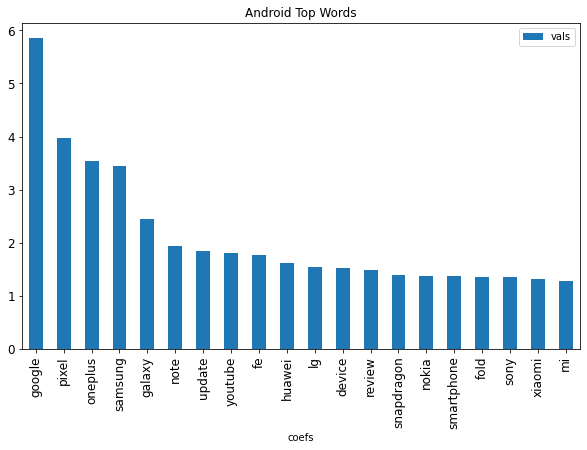

In [55]:
top_android_coef.plot(kind = 'bar', x = 'coefs', y = 'vals', 
                      fontsize = 12, figsize = (10, 6), title = 'Android Top Words')

In [56]:
iphone_coef = coef_df[coef_df['vals'] > 0]
iphone_coef['vals'] = iphone_coef['vals'].round(2)
iphone_coef.reset_index(drop = True, inplace = True)

iphone_coef.head(3)

<ipython-input-56-03bebf46b3d2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iphone_coef['vals'] = iphone_coef['vals'].round(2)


,coefs,vals
0,apple,4.60
1,pro,4.25
2,magsafe,3.13


In [57]:
iphone_coef.shape

(1946, 2)

In [58]:
iphone_coef = iphone_coef[iphone_coef['vals'] > 0]
iphone_coef.shape

(1904, 2)

<AxesSubplot:title={'center':'iPhone Top Words'}, xlabel='coefs'>

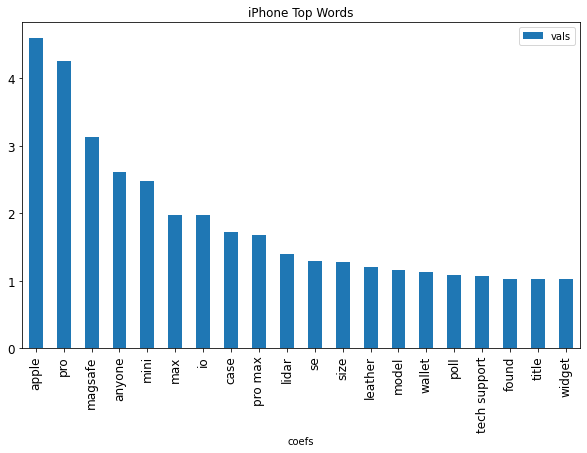

In [59]:
top_iphone_coef = iphone_coef.head(20)

top_iphone_coef.plot(kind = 'bar', x = 'coefs', y = 'vals', 
                     fontsize = 12, figsize = (10, 6), title = 'iPhone Top Words')

### 3.1  Further Interpretation: Brands and Feature Names

We see that for the Android subreddit, the main classifiers are brands. Samsung, OnePlus, Huawei, and even Nokia appears as the top 20 words that identifies a post in the Android subreddit. The phone models such as 'Note', 'Pixel', 'Fold' also appear as the top 20 words.

For the iPhone subreddit, since the new iPhones for 2020 were just released about a month ago, there is a lot of discussion regarding the new features. [Magsafe](https://www.cnet.com/news/iphone-12-the-first-gen-magsafe-accessories-are-out/) and [LiDAR](https://www.techradar.com/sg/news/what-is-a-lidar-scanner-the-iphone-12-pros-rumored-camera-upgrade-anyway). Model names are also significant, such as 'Mini', 'Max' and 'SE.

Apple and Google are also top of the list as classifiers for the iPhone and Android subreddit respectively, which shows that people are very aware of the companies responsible for both products.

While these words appearing do give us a view of what kind of words redditors in each subreddit uses, we will run another model with all these classifiers put into our stopwords list. This will help us see that beyond these feature names and brands, what are the things being discussed in each Subreddit?

In [60]:
stops = set(stopwords.words('english'))
len(stops)

179

In [61]:
new_stops = {'iphone', 'iphones', 'android', 'phone',
             'http', 'amp', 'www', 'com', 'thread', 'reddit', 'automoderator',
             'apple', 'pro', 'magsafe', 'mini', 'max', 'lidar', 'se',
             'google', 'pixel', 'oneplus', 'samsung', 'galaxy', 'note',
             'fe', 'huawei', 'lg', 'snapdragon', 'exynos', 'fold', 'sony', 'nokia', 
             'xiaomi', 'mi', 'zenfone', 'poco', 'nexus', 'xperia'}
len(new_stops)

38

In [62]:
updated_stops = stops.union(new_stops)
len(updated_stops)

217

In [63]:
pipe_tv_lr = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = updated_stops)),
    ('lr', LogisticRegression())
])

In [64]:
pipe_params = {
    'tvec__max_features': [2000, 3000, 4000],
    'tvec__min_df': [3, 4],
    'tvec__max_df': [0.82, 0.85, 0.88],
    'tvec__ngram_range': [(1, 2), (1, 3)],
    'lr__C': [0.5, 1.0, 1.25]
}

In [65]:
gs_tv_lr = GridSearchCV(pipe_tv_lr, param_grid = pipe_params,
                  cv = 5, verbose = 1) 

In [66]:
gs_tv_lr.fit(X, y)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:  3.0min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words={'a',
                                                                    'about',
                                                                    'above',
                                                                    'after',
                                                                    'again',
                                                                    'against',
                                                                    'ain',
                                                                    'all', 'am',
                                                                    'amp', 'an',
                                                                    'and',
                                                                    'android',
                                                                    'any',
       

In [67]:
gs_tv_lr.best_params_

{'lr__C': 1.25,
 'tvec__max_df': 0.82,
 'tvec__max_features': 4000,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 2)}

In [68]:
tv_lr_filtered_model = gs_tv_lr.best_estimator_
tv_lr_filtered_model.score(X, y)

0.9388489208633094

In [69]:
pickle.dump(tv_lr_filtered_model, open('models/trained_model_filtered.pickle', 'wb'))

#saving the model trained on data after filtering out brand/hardware names

In [70]:
coef_names = tv_lr_filtered_model.named_steps.tvec.get_feature_names()

coef_df = pd.DataFrame({'coefs': coef_names, 'vals' : tv_lr_filtered_model.steps[1][1].coef_[0]})

coef_df.sort_values(by='vals',ascending=False, inplace = True)

In [71]:
coef_df.head()

,coefs,vals
137,anyone,3.309441
502,case,2.437425
1659,io,2.311948
3003,size,2.010148
3630,wallet,1.831369


In [72]:
coef_df.tail().sort_values(by = 'vals')

,coefs,vals
3516,update,-2.467844
3842,youtube,-2.003349
855,device,-1.944787
2384,play,-1.924120
1216,flagship,-1.672352


In [73]:
iphone_coef = coef_df[coef_df['vals'] > 0]
iphone_coef['vals'] = iphone_coef['vals'].round(2)
iphone_coef.reset_index(drop = True, inplace = True)

iphone_coef.head()

<ipython-input-73-3846431d4e3f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iphone_coef['vals'] = iphone_coef['vals'].round(2)


,coefs,vals
0,anyone,3.31
1,case,2.44
2,io,2.31
3,size,2.01
4,wallet,1.83


In [74]:
iphone_coef.shape

(1859, 2)

<AxesSubplot:title={'center':'iPhone Top Words (Filtered)'}, xlabel='coefs'>

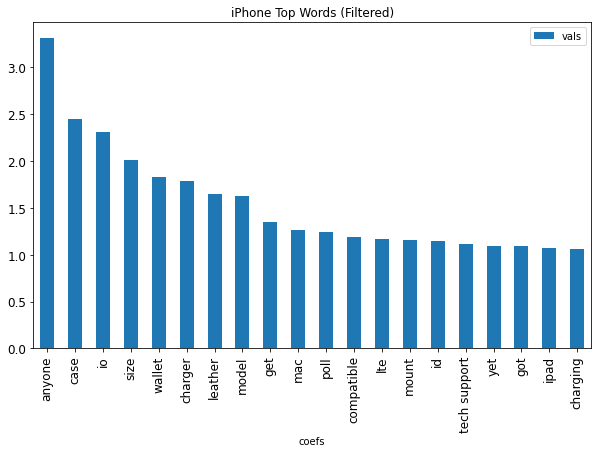

In [75]:
top_iphone_coef = iphone_coef.head(20)
top_iphone_coef.plot(kind = 'bar', x = 'coefs', y = 'vals', 
                     fontsize = 12, figsize = (10, 6), title = 'iPhone Top Words (Filtered)')

In [76]:
android_coef = coef_df[coef_df['vals'] < 0]
android_coef['vals'] = android_coef['vals'].round(2).apply(abs)

android_coef.sort_values(by = 'vals', ascending = False, inplace = True)
android_coef.reset_index(drop = True, inplace = True)

android_coef.head()

<ipython-input-76-a950e74c4786>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  android_coef['vals'] = android_coef['vals'].round(2).apply(abs)
<ipython-input-76-a950e74c4786>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  android_coef.sort_values(by = 'vals', ascending = False, inplace = True)


,coefs,vals
0,update,2.47
1,youtube,2.00
2,device,1.94
3,play,1.92
4,flagship,1.67


In [77]:
android_coef.shape

(1993, 2)

In [78]:
android_coef = android_coef[android_coef['vals'] > 0]
android_coef.shape

(1961, 2)

<AxesSubplot:title={'center':'Android Top Words (Filtered)'}, xlabel='coefs'>

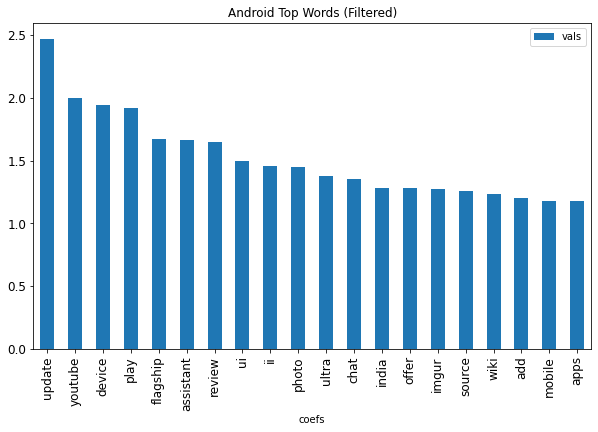

In [79]:
top_android_coef = android_coef.head(20)
top_android_coef.plot(kind = 'bar', x = 'coefs', y = 'vals', 
                      fontsize = 12, figsize = (10, 6), title = 'Android Top Words (Filtered)')

### 3.2  Final Interpretations

**What are Android fans discussing?**

Well firstly, Android is a much larger ecosystem. Looking at just devices alone, there are many brands/companies making many phones in a year. An [article from 2016](https://www.phonearena.com/news/Did-you-know-how-many-Android-phones-were-launched-last-year-Heres-the-answer_id81262) shows that there were 600 different models released in that year alone. By contrast, Apple only releases a handful of new models each year: this year they released 5 models, the most number of new models they have ever released in a year.

This is reflected in our first histogram. Brands like Google, OnePlus, Huawei, Lg, Sony and Xiaomi are all among the top words discussed. Even Nokia somehow made the list.

Model names like Pixel, Note, Galaxy, FE([Fan Edition](https://www.tomsguide.com/reviews/samsung-galaxy-s20-fe)) Fold are all among the most mentioned.

Android fans also show a bit more tech-saviness, with 'Exynos' and 'Snapdragon' among the top identifiers for the subreddit posts. But, this could also be due to the fact that these words are pretty exotic and so they stand out very strongly.

**How about iPhone fans?**

As mentioned earlier, Apple had a big iPhone release on the 13th of October, and our reddit posts start from the 22nd of October to the 26th of November. As expected, the iPhone subreddit is filled with discussions on the new features such as Magsafe, Lidar, and [Widgets](https://gizmodo.com/the-best-iphone-home-screen-widgets-weve-found-so-far-1845762820).

Model names such as SE(Special Edition), Mini, Pro, Max and Pro Max also top the list. Even some new accesories like [leather wallets](https://9to5mac.com/2020/11/02/hands-on-iphone-leather-wallet-with-magsafe/) are also discussed.

**Beyond Brands and Models**

As we mentioned earlier, we wanted to get a deeper insight on what Android and iPhone fans talk about beyond brands and hardware models. So we removed those words and here, things get a bit more interesting.

iPhone fans talk a lot about the overall Apple ecosystem: Macs, iPads, and iOS. A lot of discussions on accesories (wallet, charger, case, mount) are also carried out. All these are features of Apple's seamless but tightly controlled ecosystem. 'Compatible' and 'tech support' are also some useful key terms in this top 20 list.

Android fans discuss slightly more technical terms like 'update', 'assistant', and 'ui'(User-Interface). Certain keywords like 'device', 'flagship', and 'review' also reflect the more open and flexible nature of the Android ecosystem.

## 4.  Evaluation of Results

Here we look at the final score of our model, and delve a bit deeper into the misclassified data.
For further evaluation, of our analysis, we did another webscraping exercise and applied our train model to the new data, to have a better view of how well our model works on unseen data.

In [80]:
preds = tv_lr_filtered_model.predict(X)

In [81]:
confusion_matrix(y, preds)

array([[651,  74],
       [ 28, 915]])

In [82]:
tn, fp, fn, tp = confusion_matrix(y, preds).ravel()

print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 651
False Positives: 74
False Negatives: 28
True Positives: 915


In [83]:
(651 + 915) / (651 + 74 + 28 + 915)

0.9388489208633094

**Model Score**

Our model is able to classify 93.88% of our data correctly.

In [84]:
combined.head(3)

,cleaned_text,subreddit
0,samsung trade program back baltic country good,0
1,vivo unveils origin o le polarizing previous one,0
2,nokia hand gsmarena,0


In [85]:
combined["predicted"] = preds

In [86]:
combined.head(3)

,cleaned_text,subreddit,predicted
0,samsung trade program back baltic country good,0,0
1,vivo unveils origin o le polarizing previous one,0,0
2,nokia hand gsmarena,0,0


In [87]:
misclass = (combined['predicted'] != combined['subreddit'])

In [89]:
combined[misclass]

,cleaned_text,subreddit,predicted
6,decision factor choice phone every price point...,0,1
42,discovered galaxy open space inside creates re...,0,1
50,sony xperia compact line might making return r...,0,1
52,anyone else know skip youtube ad need press in...,0,1
53,psa calling uk number google home going away d...,0,1
...,...,...,...
1341,apple raise app store price brazil colombia in...,1,0
1356,photographer review,1,0
1420,tool used amazing could easily take still tiny...,1,0
1561,ifixit tearing live youtube,1,0


We have a total of 102 reddit posts which were misclassified.  

We will take random samples from these posts to better understand why they were wrongly classified. 

In [90]:
misclass_index = combined[misclass].index.to_list()

In [91]:
combined['subreddit'][720:730]

720    0
721    0
722    0
723    0
724    0
725    1
726    1
727    1
728    1
729    1
Name: subreddit, dtype: int64

In [92]:
android_misclass = []
iphone_misclass = []

for i in misclass_index:
    
    if i > 724:
        
        iphone_misclass.append(i)
        
    else:
        
        android_misclass.append(i)

We seperate the indexes of the wrongly classified Android subreddits and the wrongly classified iPhone subreddits into different lists. We can then use those lists to get access to both types of wrongly classified posts.

In [93]:
len(android_misclass)

74

In [94]:
len(iphone_misclass)

28

In [95]:
sample_index = sample(android_misclass, 4) + sample(iphone_misclass, 4)
sample_index

[411, 703, 238, 121, 935, 952, 1232, 991]

In [96]:
combined.iloc[sample_index, :]

,cleaned_text,subreddit,predicted
411,discussion guy replace part lived la needle sa...,0,1
703,google pixel hand question answered,0,1
238,first curious everyones first mine lg eve gw r...,0,1
121,google debut new barely blue limited edition c...,0,1
935,google photo end free unlimited storage june st,1,0
952,apple best selling smartphone q,1,0
1232,found bug went camera whilst watching youtube ...,1,0
991,version check youtube added hdr support,1,0


In [97]:
for i in sample_index:
    print(combined['cleaned_text'][i])
    print('                     ')
    print('                     ')

discussion guy replace part lived la needle say always minority keeping phone long currently hand replaced became safety hazard last year moving country realized minority large city also rural area many necessarily upper income folk replace frequently
                     
                     
google pixel hand question answered
                     
                     
first curious everyones first mine lg eve gw r piece crap lol first good galaxy nexus
                     
                     
google debut new barely blue limited edition color pixel
                     
                     
google photo end free unlimited storage june st
                     
                     
apple best selling smartphone q
                     
                     
found bug went camera whilst watching youtube landscape mode
                     
                     
version check youtube added hdr support
                     
                     


**Misclassified Posts**

Most of the posts that were classified were short posts, and they consists mainly of brand and hardware model names like 'Google', 'Pixel', 'Samsung'. With those words removed during the modelling process, these posts have very little for the model to work on and are classified wrongly.

'Youtube' is a keyword that seems to have caused a lot of misclassification too, as the model has used this word to classify Android posts. However there are posts in the iPhone subreddit which mentions Youtube as well. Again, these are short posts which mentions 'Youtube' together with iPhone brand names that were removed. This caused them to be wrongly classified as Android posts.



   
   

# 5.  Conclusions and Recommendations

The first models that were run may have showed very obvious features of the Android and iPhone ecosystem: brand names, feature names, etc. However, they do provide a lot of value: there are so many more brands and model names that were not significant in the analysis. One example is the much lauded over Samsung [Galaxy Z Flip](https://www.samsung.com/sg/smartphones/galaxy-z-flip/), a new type of foldable smartphone. This did not seem to get much traction on reddit despite heavy marketing. A new product by Microsoft called the [Surface Duo](https://www.microsoft.com/en-us/surface/devices/surface-duo?activetab=overview) did not appear as well.

Similarly, there were certain iPhone features that were released but did not get much traction. The new iPhones released in October came with [Dolby Vision HDR video recording](https://www.imore.com/what-dolby-vision-and-why-does-it-matter-iphone-12), but this did not seem to get any mention at all.

So while the first analysis might seem obvious, it does provide value by showing which brands and features get traction among the customer base. This will give direction as to what they can improve on in their future products.

The second analysis shows the different priorities customers of the different smartphone platforms prioritises.
Android fans seem to focus on technical aspects such as processor brand ('Snapdragon' and 'Exynos' both appear as top classifiers), digital assistant, 'flagship' devices. iPhone fans prioritise the overall ecosystem of the iPhone, such as iPads, Macs, reliable tech support and the strong Apple accesory ecosystem.

This provides vast value to anyone invested in the smartphone market, or are attempting to profit from it. By understanding the needs/preferences of customers of each platform, stakeholders will be better able to engage those customers.